# Homework 4 - Optimization

Reaction Network:
1. $HCHO + \frac{1}{2}O_2 \rightarrow HCOOH$ with $k_1$
2. $2HCHO \rightarrow HCOOCH_3$ with $k_2$
3. $HCOOH \rightarrow CO + H_2O$ with $k_3$
4. $HCOOCH_3 \rightarrow CH_3OH + HCOOH$ with $k_4$
5. $HCOOH + \frac{1}{2}O2 \rightarrow CO2 + H2O$

Let A = $HCHO$, B = $O_2$, C = HCOOH, D = $HCOOCH_3$, E = CO, W = $H_2O$, G = $CH_3OH$

Initial flow conditions:
* FA0 = 10 mol/s
* FB0 = 5 mol/s
* v0 = 100 L/s
* V = 1000L

Constant temperature and pressure liquid reaction (v = v0)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar #There are two commonly used optimization functions, depending whether your function of inters returns a scalar or a vector.
from scipy.optimize import minimize
from scipy.integrate import odeint
%matplotlib inline

In [3]:
#Define kinetics constants
k1 = 0.014
k2 = 0.004
k3 = 0.04
k4 = 0.45 
k5 = 0.01

#Define a function to return the rates from an input vector of the species concentrations
def rate(C): #For simplicity have the k's as global variables
    CA, CB, CC, CD, CE, CW, CG, CH = C
    rA = -k1*CA*CB**0.5 - 2*k2*CA**2
    rB = -0.5*k1*CA*CB**0.5-0.5*k5*CC*CB**2
    rC = k1*CA*CB**0.5+k4*CD**2-k5*CC*CB**2-k3*CC
    rD = k2*CA**2-k4*CD**2
    rE = k3*CC
    rW = k3*CC+k5*CC*CB**2
    rG = k4*CD**2
    rH = k5*CC*CB**2
    return rA, rB, rC, rD, rE, rW, rG, rH

In [4]:
T = 300. #K
v0 = 10. #L/s
V = 1000. #L

V_range = np.linspace(0, V, 100)

FA0 = 10

#### Define functions to integrate along length of PFR


In [5]:
def deriv(F, V, FT0): 
    FT = np.sum(F)
    v = v0*FT/FT0
    CA, CB, CC, CD, CE, CW, CG, CH = F/v
    C = np.array([CA, CB, CC, CD, CE, CW, CG, CH])
    #print(C)
    dFAdV, rdFBdV, dFCdV, dFDdV, dFEdV, dFWdV, dFGdV, dFHdV = rate(C)
    return [dFAdV, rdFBdV, dFCdV, dFDdV, dFEdV, dFWdV, dFGdV, dFHdV]

In [6]:
def integrate(F0, V):
    V_range = np.linspace(0, V, 100)
    sol = odeint(deriv, F0, V_range, args=(np.sum(F0),))
    return sol, V_range

## Define a vetor function to calculate selectivity
Which takes as arguments $\theta_B$ and V

In [7]:
def find_S_C(x):
    theta_B = x[0]
    V = x[1]
    F0 = [FA0, FA0*theta_B, 0, 0, 0, 0, 0, 0]
    sol, V_range = integrate(F0, V)
    S_C = sol[-1,2]/(sol[-1, 0]+sol[-1, 4]+sol[-1,6]+sol[-1,7])
    return -1*S_C

Calculate the optimum parameters

In [8]:
opt = minimize(find_S_C, [0.5, 1000], bounds = ((0.1, 2.), (100, 1000.)))

In [9]:
opt

      fun: -0.22388228723940162
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.11363696e-04,  6.32827124e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 126
      nit: 20
   status: 0
  success: True
        x: array([  1.16919785, 317.67896501])

## Optimum Conditions:
$\theta_B$ = 1.17

V = 317 L

To analyze, let's generate some more plots

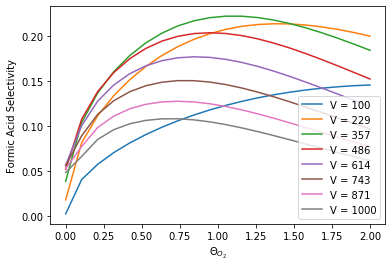

In [10]:
#Test a range of input FB0 and reactor volumes for the effect on selectivity
FB0_range = np.linspace(0, 2., 20)
V_test = np.linspace(100, 1000, 8)

S_C = np.zeros((len(FB0_range),len(V_test)))
FS_C = np.zeros((len(FB0_range),len(V_test)))

for i in range(len(FB0_range)):
    for j in range(len(V_test)):
        F0 = np.array([FA0, FB0_range[i]*FA0, 0, 0, 0, 0, 0, 0])
        sol, V_range = integrate(F0, V_test[j])
        sol = np.asarray(sol)
        S_C[i,j] = sol[-1,2]/(sol[-1, 0]+sol[-1, 4]+sol[-1,6]+sol[-1,7])
        FS_C[i,j] = sol[-1,2]*S_C[i,j]
    
plt.figure()    
for j in range(len(V_test)):
    plt.plot(FB0_range, S_C[:,j], label = f'V = {float(V_test[j]):.0f}')
plt.xlabel(r'$\Theta_{O_2}$')
plt.ylabel('Formic Acid Selectivity')
plt.legend()

## Explanation

With no oxygen, the production of methyl formate dominates over the production of formic acid (reaction 2 vs reaction 1). Although methyl formate eventualyl decomposes to produce formic acid, selectivity is optimized by using the oxygen-dependent pathway as it avoids the co-formation of methanol. However, at high concentrations of O2, we see overoxidation of formaldehyde to CO2, which reduces selectivity. Thus the optimum for oxygen occurs because at low concentration selectivity is low due to methanol formation, and at high concentration selectivity is low due to CO2 production. 

For a very small reactor, slectivity is low because the methyl formate doesn't have a chance to decompose to formic acid, even at the highest concentrations of O2. In a very large reactor, selectivity drops because of the production of CO2. 

So, it is important to balance both the O2 inlet as well as the overall reactor size to maximize selectivity